### Label Propragation and Spreading 

In [1]:
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.semi_supervised import LabelSpreading, LabelPropagation
from sklearn.metrics import accuracy_score, roc_auc_score, balanced_accuracy_score, matthews_corrcoef
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tabulate import tabulate

In [2]:
import warnings
warnings.simplefilter('ignore') #we don't wanna see that
np.random.seed(1) #i'm locking seed at the begining since we will use some heavy RNG stuff, be aware

Test on Lung CRISPR data with Curated Bagel E and NE as labels

In [3]:
df_lung = pd.read_csv("Lung_CRISPR.csv", index_col=0)
index = df_lung.index.tolist()
idx = [ i.split('(', 1)[0].strip() for i in index]
df_lung.reset_index(drop=True)
df2_lung = pd.DataFrame(df_lung.to_numpy(), index=idx, columns=df_lung.columns)
df2_lung

,Lung ACH-000012,Lung ACH-000015,Lung ACH-000021,Lung ACH-000029,Lung ACH-000030,Lung ACH-000035,Lung ACH-000143,Lung ACH-000150,Lung ACH-000161,Lung ACH-000187,...,Lung ACH-000176,Lung ACH-000282,Lung ACH-000442,Lung ACH-000562,Lung ACH-000666,Lung ACH-000894,Lung ACH-000945,Lung ACH-001137,Lung ACH-001233,Lung ACH-002156
A1BG,-0.108980,-0.189235,-0.105938,-0.021076,-0.016582,-0.067664,-0.119212,0.125060,-0.014279,-0.073889,...,-0.054437,0.034093,0.057533,-0.133443,-0.003102,-0.026487,0.097041,-0.066143,-0.058657,-0.106796
A1CF,0.058620,-0.035974,-0.128983,0.021592,-0.252811,0.010632,-0.259819,0.055429,-0.018668,0.073300,...,0.074430,0.169736,0.205212,0.214558,-0.139011,-0.065532,0.232760,0.068774,-0.156786,0.136343
A2M,0.172384,-0.081227,-0.031955,0.061565,0.061437,0.013058,-0.032307,-0.107358,0.078105,-0.114860,...,-0.020439,-0.132270,-0.154406,0.030255,0.245718,-0.097719,0.006453,0.066938,-0.004401,0.047201
A2ML1,0.223336,0.040641,-0.037817,0.124352,0.127381,0.031293,-0.072596,0.067760,0.098264,0.115993,...,0.169129,-0.066514,0.239753,0.190899,-0.081751,0.131874,-0.025697,0.213979,0.119160,0.261219
A3GALT2,0.119961,0.073002,-0.008492,-0.202661,-0.111409,-0.039283,-0.032018,-0.074665,-0.118834,-0.187936,...,0.023983,-0.216107,-0.325557,-0.006391,-0.027773,-0.194807,-0.155381,-0.230956,0.005990,-0.255882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,0.022825,-0.002087,-0.011769,0.018795,-0.064730,-0.227280,0.085573,-0.076451,0.036753,-0.001422,...,-0.074062,-0.060480,-0.124188,0.069443,-0.023997,0.017859,-0.028109,-0.042222,-0.100133,-0.118193
ZYG11B,-0.067238,-0.123983,-0.210983,-0.067246,-0.197020,-0.347596,-0.101911,0.013915,-0.005542,-0.004455,...,-0.137992,-0.171666,-0.118732,-0.163424,-0.029105,-0.343399,-0.163772,-0.334588,-0.101049,-0.217907
ZYX,-0.138806,-0.090832,-0.292636,0.007300,0.051397,-0.054946,0.006333,0.044104,-0.074138,0.018319,...,0.106957,-0.142906,0.091290,0.085370,-0.051036,0.086529,-0.039301,0.043595,-0.030006,0.062295
ZZEF1,-0.063841,-0.182880,-0.127955,-0.091112,-0.076670,-0.039142,0.115756,-0.188083,-0.065650,-0.097660,...,0.037841,-0.442399,-0.117184,-0.225227,-0.004863,-0.059501,-0.327515,-0.323785,-0.209962,-0.319088


In [ ]:
#es = pd.read_csv("Hart2014.csv")
es = pd.read_csv("Hart2017_essential.csv")
#es = pd.read_csv("Sharma2020_joined.csv")
len(list(es.iloc[:,0])), len(set(list(es.iloc[:,0])))
nes = pd.read_csv("curated_bagel_not_essential.csv")
es['Label'] = 1
nes['Label'] = 0
data = pd.concat((es, nes), ignore_index=True, axis=0)
print(es.shape, nes.shape)
data

In [ ]:
e1 = es.iloc[:,0].to_numpy()
e2 = nes.iloc[:,0].to_numpy()
df_idx = df2_lung.index.to_numpy()
#print(df_idx[:10])
df_idx = np.asarray([ i.strip() for i in df_idx])
#df_idx[:10]
#idxs.to_csv("CRIPSRIndex.csv", index=None)
#print(e1.shape, df_idx.shape)
common_es = list(np.intersect1d(e1, df_idx))
common_nes = list(np.intersect1d(e2, df_idx))
common_all = common_es+ common_nes
len(common_es), len(common_nes), len(common_all)

In [ ]:
data.set_index('Gene', inplace=True)
data

In [ ]:
data.drop(index=common_all).shape, data.loc[common_all].shape

In [ ]:
X_labeled = df2_lung.loc[common_all]#.to_numpy()
X_unlabeled = df2_lung.drop(common_all)#.to_numpy()
y_labeled = data.loc[common_all]#.to_numpy().flatten()
X_labeled.shape, X_unlabeled.shape, y_labeled.shape, df2_lung.shape

In [ ]:
if X_labeled.shape[0] + X_unlabeled.shape[0] != df2_lung.shape[0]:
    print("shape mismatch: yes")
    print(X_labeled.shape[0] + X_unlabeled.shape[0], df2_lung.shape[0])

In [ ]:
#model = LabelSpreading('knn', max_iter=1000, tol=0.001)
#X_train_combined = np.vstack((X_labeled, X_unlabeled))
#y_train_combined = np.concatenate((y_labeled.iloc[:,0], [-1] * len(X_unlabeled)))  #-1 
#X_labeled.shape, X_unlabeled.shape, y_labeled.shape
#model.fit(X_train_combined, y_train_combined)

In [ ]:
def LabelProp_n_Spread(method, X_labeled, X_unlabeled, y_labeled):
    if method == 'propa':
        model = LabelPropagation('knn', max_iter=100000, tol=0.0001)
    elif method == 'spread':
        model = LabelSpreading('knn', max_iter=1000, tol=0.001)
    n_folds=5
    #Create a cross-validation iterator
    cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    #cv = StratifiedKFold(n_splits=n_folds, shuffle=False, random_state=None)

    #Lists to store performance metrics from each fold
    roc_scores = []
    acc_scores = []
    ba_scores = []
    mcc_scores = []
    #Cross-validation loop
    for i, (train_index, test_index) in enumerate(cv.split(X_labeled, y_labeled)):
        # Create training and testing sets for this fold
        X_train = X_labeled.iloc[train_index]
        y_train = y_labeled.iloc[train_index]
        X_test = X_labeled.iloc[test_index]
        y_test = y_labeled.iloc[test_index]
        
        #    # Combine a portion of the unlabeled data with the labeled data for training
        X_train_combined = np.vstack((X_train, X_unlabeled))
        y_train_combined = np.concatenate((y_train.iloc[:,0], [-1] * len(X_unlabeled)))  #-1 as a placeholder for unlabeled data
        model.fit(X_train_combined, y_train_combined)
        y_pred = model.predict(X_test)
        acc_scores.append(accuracy_score(y_test, y_pred)) # accuracy_score(y_test, y_pred_lp)])
        ba_scores.append(balanced_accuracy_score(y_test, y_pred))
        mcc_scores.append(matthews_corrcoef(y_test, y_pred))
        roc_scores.append(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
    scores = pd.DataFrame(np.vstack((acc_scores, ba_scores, roc_scores, mcc_scores)).T,  columns=['ACC', 'BA', 'ROC', 'MCC'])
        
    return model, scores
#print(f' Mean and Std from Cross-Validation :\n')
#print(f' ACC = {np.mean(acc_scores):.4f} \u00B1 {np.std(acc_scores):.4f}')
#print(f' BA = {np.mean(ba_scores):.4f} \u00B1 {np.std(ba_scores):.4f}'   )
#print(f' ROC = {np.mean(roc_scores):.4f} \u00B1 {np.std(roc_scores):.4f}')
#print(f' MCC = {np.mean(mcc_scores):.4f} \u00B1 {np.std(mcc_scores):.4f}')

In [ ]:
model_ls, scores_ls = LabelProp_n_Spread('spread', X_labeled, X_unlabeled, y_labeled)

In [ ]:
scores_ls

In [ ]:
y_label_pred = 

In [ ]:
scores_ls.describe()

In [ ]:
scores_ls.columns = ['ACC', 'BA', 'ROC', 'MCC']
scores_ls

In [ ]:
y_pred_ls = model_ls.predict(X_unlabeled)
np.count_nonzero(y_pred_ls == 1), np.count_nonzero(y_pred_ls == 0) 

In [ ]:
np.count_nonzero(y['Label'] == 1)

In [ ]:
dfout = pd.DataFrame({'Gene':X_unlabeled.index.tolist(),'Label':y_pred_ls})
dfout.set_index('Gene', inplace=True)
dfout.to_csv('LabelSpreading_lung.csv')

test ROC-AUC error Label Propagation

In [ ]:
#model_lp = LabelPropagation('knn', max_iter=100000, tol=0.0001)
#X_train_combined = np.vstack((X_train, X_unlabeled))
#y_train_combined = np.concatenate((y_train.iloc[:,0], [-1] * len(X_unlabeled)))  #-1 as a placeholder for unlabeled data
#model_lp.fit(X_train_combined, y_train_combined)
#y_pred = model.predict(X_test)

In [ ]:
model = LabelPropagation('knn', max_iter=100000, tol=0.0001)
n_folds=5
#Create a cross-validation iterator
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

#Lists to store performance metrics from each fold
roc_scores = []
acc_scores = []
ba_scores = []
mcc_scores = []
#Cross-validation loop
for i, (train_index, test_index) in enumerate(cv.split(X_labeled, y_labeled)):
    # Create training and testing sets for this fold
    X_train = X_labeled.iloc[train_index]
    y_train = y_labeled.iloc[train_index]
    X_test = X_labeled.iloc[test_index]
    y_test = y_labeled.iloc[test_index]
    
    #    # Combine a portion of the unlabeled data with the labeled data for training
    X_train_combined = np.vstack((X_train, X_unlabeled))
    y_train_combined = np.concatenate((y_train.iloc[:,0], [-1] * len(X_unlabeled)))  #-1 as a placeholder for unlabeled data
    model.fit(X_train_combined, y_train_combined)
    y_pred = model.predict(X_test)
    acc_scores.append(accuracy_score(y_test, y_pred)) # accuracy_score(y_test, y_pred_lp)])
    ba_scores.append(balanced_accuracy_score(y_test, y_pred))
    mcc_scores.append(matthews_corrcoef(y_test, y_pred))
#    roc_scores.append(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
    roc_scores.append(roc_auc_score(y_test, y_pred ))
#scores = pd.DataFrame(np.vstack((acc_scores, ba_scores, roc_scores, mcc_scores)).T)
        

In [ ]:
roc_scores

In [ ]:
np.mean(roc_scores), np.std(roc_scores)

In [ ]:
model_lp, scores_lp = LabelProp_n_Spread('propa', X_labeled, X_unlabeled, y_labeled)

In [ ]:
scores_lp

In [ ]:
scores_lp = pd.DataFrame(np.vstack((acc_scores, ba_scores, mcc_scores)).T, columns=['ACC', 'BA', 'MCC'])
scores_lp.to_csv('scores_lp.csv')

In [ ]:
!head scores_lp.csv

In [ ]:
scores_ls.to_csv('scores_ls.csv')

In [ ]:
model

In [ ]:
y_pred_lp = model.predict(X_unlabeled)
np.count_nonzero(y_pred_lp == 1), np.count_nonzero(y_pred_lp == 0) 

In [ ]:
dfout2 = pd.DataFrame({'Gene':X_unlabeled.index.tolist(),'Label':y_pred_lp})
dfout2.set_index('Gene', inplace=True)
dfout2.to_csv('LabelPropagation_lung.csv')

In [ ]:
import matplotlib.pyplot as plt

### In terquartile range (IQR) 

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [5]:
X = df2_lung.to_numpy()
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
pca.fit(X)
#X_pca = pca.fit_transform(df2_lung.to_numpy())
print(pca.explained_variance_ratio_)

[0.87760446 0.00582903]


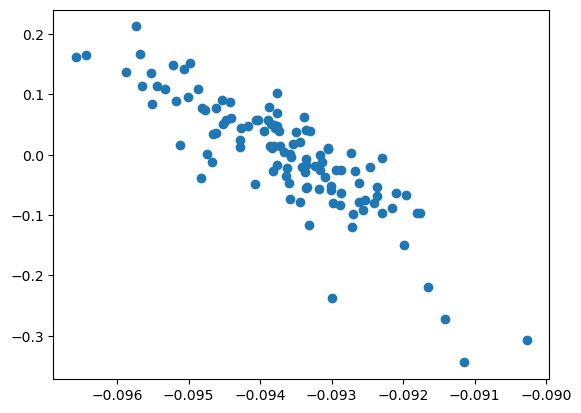

In [6]:
X_res = pca.components_
plt.scatter(X_res[0], X_res[1] )
#plt.scatter(X_pca[:,0], X_pca[:,1] )

In [7]:
df_pca = pd.DataFrame(X_res, columns=df2_lung.columns, index=['PC1', 'PC2'])
df_pca

,Lung ACH-000012,Lung ACH-000015,Lung ACH-000021,Lung ACH-000029,Lung ACH-000030,Lung ACH-000035,Lung ACH-000143,Lung ACH-000150,Lung ACH-000161,Lung ACH-000187,...,Lung ACH-000176,Lung ACH-000282,Lung ACH-000442,Lung ACH-000562,Lung ACH-000666,Lung ACH-000894,Lung ACH-000945,Lung ACH-001137,Lung ACH-001233,Lung ACH-002156
PC1,-0.093545,-0.091982,-0.094773,-0.093828,-0.093357,-0.092104,-0.092159,-0.093389,-0.093633,-0.093758,...,-0.092291,-0.094653,-0.093577,-0.091800,-0.094036,-0.093006,-0.092368,-0.093179,-0.093718,-0.093341
PC2,0.017519,-0.149777,0.073477,0.011520,-0.007740,-0.063419,-0.088832,0.062085,-0.034448,0.047986,...,-0.004800,0.033629,-0.072747,-0.096748,0.057688,-0.057852,-0.053057,-0.056495,0.014145,-0.053294


In [121]:
def determine_outlier_iqr(dataframe, row_name, th1=0.25, th3=0.75):
    quartile1 = dataframe.loc[row_name].quantile(th1)
    quartile3 = dataframe.loc[row_name].quantile(th3)
    iqr = quartile3 - quartile1
    upper_limit = quartile3 + 1.5 * iqr
    lower_limit = quartile1 - 1.5 * iqr
    return lower_limit, upper_limit

rows = df2_lung.index.tolist()
tmp = []
res = df2_lung.copy()
out_mask = None
for row in rows:
    lower_limit, upper_limit = determine_outlier_iqr(df2_lung, row, 0.25, 0.75)
    #print(lower_limit, upper_limit)
   # tmp.append(df2_lung.loc[row, (df2_lung.loc[row] <= lower_limit) | (df2_lung.loc[row] >= upper_limit)])
    out_mask = (df2_lung.loc[row] <= lower_limit) | (df2_lung.loc[row] >= upper_limit)
    res.loc[row, out_mask] = None
res

    #print(tmp)
    #print("")
#outliners = pd.DataFrame(tmp)
#df_cleaned = df2_lung.drop(outliners.columns)
#outliners


,Lung ACH-000012,Lung ACH-000015,Lung ACH-000021,Lung ACH-000029,Lung ACH-000030,Lung ACH-000035,Lung ACH-000143,Lung ACH-000150,Lung ACH-000161,Lung ACH-000187,...,Lung ACH-000176,Lung ACH-000282,Lung ACH-000442,Lung ACH-000562,Lung ACH-000666,Lung ACH-000894,Lung ACH-000945,Lung ACH-001137,Lung ACH-001233,Lung ACH-002156
A1BG,-0.108980,-0.189235,-0.105938,-0.021076,-0.016582,-0.067664,-0.119212,0.125060,-0.014279,-0.073889,...,-0.054437,0.034093,0.057533,-0.133443,-0.003102,-0.026487,0.097041,-0.066143,-0.058657,-0.106796
A1CF,0.058620,-0.035974,-0.128983,0.021592,-0.252811,0.010632,-0.259819,0.055429,-0.018668,0.073300,...,0.074430,0.169736,0.205212,0.214558,-0.139011,-0.065532,0.232760,0.068774,-0.156786,0.136343
A2M,0.172384,-0.081227,-0.031955,0.061565,0.061437,0.013058,-0.032307,-0.107358,0.078105,-0.114860,...,-0.020439,-0.132270,-0.154406,0.030255,NaN,-0.097719,0.006453,0.066938,-0.004401,0.047201
A2ML1,0.223336,0.040641,-0.037817,0.124352,0.127381,0.031293,-0.072596,0.067760,0.098264,0.115993,...,0.169129,-0.066514,0.239753,0.190899,-0.081751,0.131874,-0.025697,0.213979,0.119160,0.261219
A3GALT2,0.119961,0.073002,-0.008492,-0.202661,-0.111409,-0.039283,-0.032018,-0.074665,-0.118834,-0.187936,...,0.023983,-0.216107,-0.325557,-0.006391,-0.027773,-0.194807,-0.155381,-0.230956,0.005990,-0.255882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,0.022825,-0.002087,-0.011769,0.018795,-0.064730,-0.227280,0.085573,-0.076451,0.036753,-0.001422,...,-0.074062,-0.060480,-0.124188,0.069443,-0.023997,0.017859,-0.028109,-0.042222,-0.100133,-0.118193
ZYG11B,-0.067238,-0.123983,-0.210983,-0.067246,-0.197020,-0.347596,-0.101911,0.013915,-0.005542,-0.004455,...,-0.137992,-0.171666,-0.118732,-0.163424,-0.029105,-0.343399,-0.163772,-0.334588,-0.101049,-0.217907
ZYX,-0.138806,-0.090832,NaN,0.007300,0.051397,-0.054946,0.006333,0.044104,-0.074138,0.018319,...,0.106957,-0.142906,0.091290,0.085370,-0.051036,0.086529,-0.039301,0.043595,-0.030006,0.062295
ZZEF1,-0.063841,-0.182880,-0.127955,-0.091112,-0.076670,-0.039142,0.115756,-0.188083,-0.065650,-0.097660,...,0.037841,NaN,-0.117184,-0.225227,-0.004863,-0.059501,-0.327515,-0.323785,-0.209962,-0.319088


In [122]:
# no NaN in row per gene
res.isna().sum(axis=1)

A1BG       1
A1CF       1
A2M        3
A2ML1      3
A3GALT2    3
          ..
ZYG11A     2
ZYG11B     5
ZYX        4
ZZEF1      3
ZZZ3       2
Length: 17453, dtype: int64

In [129]:
res.shape[1]*0.8

91.2

In [128]:
list(res.isnull().sum() < res.shape[1]*0.8)

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [134]:
res.loc[:, res.isnull().sum() < 119 ]

,Lung ACH-000339,Lung ACH-000414,Lung ACH-000416,Lung ACH-000438,Lung ACH-000481,Lung ACH-000525,Lung ACH-000585,Lung ACH-000587,Lung ACH-000677,Lung ACH-000769,...,Lung ACH-000787,Lung ACH-000837,Lung ACH-000841,Lung ACH-000843,Lung ACH-000858,Lung ACH-000866,Lung ACH-000867,Lung ACH-000886,Lung ACH-000888,Lung ACH-000980
A1BG,-0.026510,-0.099006,0.007257,0.052607,0.016696,-0.017569,0.024271,0.005526,-0.081032,-0.076599,...,-0.038747,-0.127387,-0.012055,-0.123169,-0.021956,0.042515,-0.027397,0.038820,-0.073536,-0.064137
A1CF,-0.043534,0.001376,-0.029660,-0.127421,-0.148994,-0.001557,0.051287,-0.045419,-0.124349,-0.046779,...,-0.014233,-0.075320,-0.027454,0.035489,-0.016003,-0.070608,-0.040869,-0.145777,-0.105366,0.004021
A2M,0.044763,0.040511,0.082266,0.018568,0.095663,0.101302,0.017870,-0.005763,-0.109090,-0.153323,...,0.049690,0.009470,-0.010149,-0.060508,0.046364,0.063982,-0.046705,0.075661,0.102651,-0.020640
A2ML1,0.059755,-0.021079,0.158219,0.174232,0.166851,0.133780,0.085761,0.128725,-0.033335,-0.011569,...,0.122508,0.082513,0.019280,0.195031,0.094791,0.008046,0.062817,0.050153,0.084720,0.051441
A3GALT2,0.075544,0.064696,-0.031443,-0.118140,-0.065214,-0.124038,-0.162838,-0.074880,-0.222252,-0.026192,...,-0.009051,-0.030706,-0.060689,-0.092364,-0.157720,-0.000533,-0.070425,-0.091097,-0.063412,-0.179816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,-0.032286,-0.087744,0.033756,-0.177656,-0.030044,-0.107884,-0.151776,-0.055787,-0.168241,-0.017745,...,-0.125900,-0.064145,0.032620,-0.044904,-0.037034,0.026091,0.042135,0.030670,-0.100005,-0.036626
ZYG11B,-0.003772,-0.164174,-0.001819,-0.146340,-0.176876,-0.094211,-0.280996,-0.184257,-0.347682,-0.133289,...,-0.145175,-0.169193,-0.155931,-0.060735,-0.171142,-0.184805,-0.047526,-0.081140,-0.168977,-0.230674
ZYX,-0.180666,-0.016546,-0.065951,0.016709,0.096702,-0.126763,-0.005345,-0.004227,-0.068158,0.054105,...,-0.054251,0.022732,0.081755,0.012233,0.032154,0.047006,-0.065578,-0.207980,0.032832,0.121251
ZZEF1,-0.098551,-0.088919,-0.020222,-0.022686,-0.035292,-0.146909,-0.202296,-0.118678,-0.256123,-0.123050,...,-0.060837,-0.040840,0.036175,-0.158323,-0.196434,-0.025833,-0.147605,-0.094701,-0.203504,-0.170212


In [146]:
# Create a sample DataFrame
data = {'A': [1, 2, 3, 4, 5],
        'B': [5, 4, 3, 2, 1],
        'C': [1, 2, 3, None, None],
        'D': [None, None, None, None, None]}

df = pd.DataFrame(data)

# Define the threshold for non-null values (e.g., 3 non-null values)
threshold = 10

# Remove columns with fewer than 'threshold' non-null values
df_cleaned = df.dropna(axis=1, thresh=4)
print(df)
print("")
print(df_cleaned)

   A  B    C     D
0  1  5  1.0  None
1  2  4  2.0  None
2  3  3  3.0  None
3  4  2  NaN  None
4  5  1  NaN  None

   A  B
0  1  5
1  2  4
2  3  3
3  4  2
4  5  1


In [162]:
res.dropna(axis='columns', thresh=10)

,Lung ACH-000012,Lung ACH-000015,Lung ACH-000021,Lung ACH-000029,Lung ACH-000030,Lung ACH-000035,Lung ACH-000143,Lung ACH-000150,Lung ACH-000161,Lung ACH-000187,...,Lung ACH-000176,Lung ACH-000282,Lung ACH-000442,Lung ACH-000562,Lung ACH-000666,Lung ACH-000894,Lung ACH-000945,Lung ACH-001137,Lung ACH-001233,Lung ACH-002156
A1BG,-0.108980,-0.189235,-0.105938,-0.021076,-0.016582,-0.067664,-0.119212,0.125060,-0.014279,-0.073889,...,-0.054437,0.034093,0.057533,-0.133443,-0.003102,-0.026487,0.097041,-0.066143,-0.058657,-0.106796
A1CF,0.058620,-0.035974,-0.128983,0.021592,-0.252811,0.010632,-0.259819,0.055429,-0.018668,0.073300,...,0.074430,0.169736,0.205212,0.214558,-0.139011,-0.065532,0.232760,0.068774,-0.156786,0.136343
A2M,0.172384,-0.081227,-0.031955,0.061565,0.061437,0.013058,-0.032307,-0.107358,0.078105,-0.114860,...,-0.020439,-0.132270,-0.154406,0.030255,NaN,-0.097719,0.006453,0.066938,-0.004401,0.047201
A2ML1,0.223336,0.040641,-0.037817,0.124352,0.127381,0.031293,-0.072596,0.067760,0.098264,0.115993,...,0.169129,-0.066514,0.239753,0.190899,-0.081751,0.131874,-0.025697,0.213979,0.119160,0.261219
A3GALT2,0.119961,0.073002,-0.008492,-0.202661,-0.111409,-0.039283,-0.032018,-0.074665,-0.118834,-0.187936,...,0.023983,-0.216107,-0.325557,-0.006391,-0.027773,-0.194807,-0.155381,-0.230956,0.005990,-0.255882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,0.022825,-0.002087,-0.011769,0.018795,-0.064730,-0.227280,0.085573,-0.076451,0.036753,-0.001422,...,-0.074062,-0.060480,-0.124188,0.069443,-0.023997,0.017859,-0.028109,-0.042222,-0.100133,-0.118193
ZYG11B,-0.067238,-0.123983,-0.210983,-0.067246,-0.197020,-0.347596,-0.101911,0.013915,-0.005542,-0.004455,...,-0.137992,-0.171666,-0.118732,-0.163424,-0.029105,-0.343399,-0.163772,-0.334588,-0.101049,-0.217907
ZYX,-0.138806,-0.090832,NaN,0.007300,0.051397,-0.054946,0.006333,0.044104,-0.074138,0.018319,...,0.106957,-0.142906,0.091290,0.085370,-0.051036,0.086529,-0.039301,0.043595,-0.030006,0.062295
ZZEF1,-0.063841,-0.182880,-0.127955,-0.091112,-0.076670,-0.039142,0.115756,-0.188083,-0.065650,-0.097660,...,0.037841,NaN,-0.117184,-0.225227,-0.004863,-0.059501,-0.327515,-0.323785,-0.209962,-0.319088


In [ ]:
#def determine_outlier_thresholds_iqr(dataframe, row_name, th1=0.25, th3=0.75):
#    quartile1 = dataframe.loc[row_name].quantile(th1)
#    quartile3 = dataframe.loc[row_name].quantile(th3)
#    iqr = quartile3 - quartile1
#    upper_limit = quartile3 + 1.5 * iqr
#    lower_limit = quartile1 - 1.5 * iqr
#    return lower_limit, upper_limit
#
#def determine_outlier_thresholds_std(dataframe, row_name):
#    upper_boundary = dataframe.loc[row_name].mean() + 3 * dataframe.loc[row_name].std()
#    lower_boundary = dataframe.loc[row_name].mean() - 3 * dataframe.loc[row_name].std()
#    return lower_boundary, upper_boundary
#
#def check_outliers(dataframe, row_name, model):
#    if model == 'iqr':
#        lower_limit, upper_limit = determine_outlier_thresholds_iqr(dataframe, row_name)
#    elif model == 'gau':
#        lower_limit, upper_limit = determine_outlier_thresholds_std(dataframe, row_name)
#   # print(lower_limit, upper_limit)
#   # print(dataframe.loc[row_name])
#    if (dataframe.loc[row_name] > upper_limit).any() | ( dataframe.loc[row_name] < lower_limit).any():
#   # if dataframe[(dataframe.loc[row_name] > upper_limit) | (dataframe.loc[row_name] < lower_limit)].any(axis=None):
#        return True
#    else: 
#        return False
#
#def replace_with_thresholds(dataframe, model='iqr', th1=0.05, th3=0.95, replace=False):
#    table = []
#    res = []
#    rows = dataframe.index.tolist()
#    for row_name in rows[:1]:
#        print(row_name)
#        if row_name != 'Outcome':
#            outliers_ = check_outliers(dataframe, row_name, model)
#            print(outliers_)
#            count = None
#            if model == 'gau':
#                lower_limit, upper_limit = determine_outlier_thresholds_std(dataframe, row_name)
#            elif model == 'iqr':
#                lower_limit, upper_limit = determine_outlier_thresholds_iqr(dataframe, row_name, th1, th3)
#            if outliers_:
#             #   print(row_name, lower_limit, upper_limit)
#             #   print(dataframe.loc[row_name])
#                print([dataframe.loc[row_name] > upper_limit]
#               # count = dataframe[(dataframe.loc[row_name] > upper_limit) | (dataframe.loc[row_name] < lower_limit)][row_name].count()
#                print("----")
#             #   print(dataframe.loc[dataframe[row_name] < lower_limit, row_name])
#               # res.append(dataframe.loc[dataframe[row_name] < lower_limit, row_name].index.tolist() )
#               # print(" ---")
#                #print(dataframe.loc[dataframe[row_name] >= upper_limit, row_name])
#               # dik dataframe.loc[dataframe[row_name] > upper_limit, row_name]
#                #if replace:
#                   # dataframe.loc[dataframe[row_name] < lower_limit, row_name] = lower_limit
#                   # print(dataframe.loc[dataframe[row_name] <= lower_limit, row_name])
#               # dataframe.loc[dataframe[row_name] > upper_limit, row_name] = upper_limit      
#               # if replace: 
#               #     if lower_limit < 0:
#               #         print("ok")
#               #         # We don't want to replace with negative values, right!
#               #         print(dataframe.loc[(dataframe[row_name] > upper_limit), row_name])
#               #         print(dataframe.loc[dataframe[row_name] > upper_limit, row_name])
#               #         dataframe.loc[dataframe[row_name] > upper_limit, row_name] = upper_limit
#               #         print(dataframe.loc[(dataframe[row_name] > upper_limit), row_name])
#               #     else:
#               #         #print(dataframe.loc[(dataframe[row_name] < lower_limit), row_name])
#               #         #print(dataframe.loc[(dataframe[row_name] > upper_limit), row_name])
#               #         print("2ok ")
#               #         dataframe.loc[(dataframe[row_name] < lower_limit), row_name] = lower_limit
#               #         dataframe.loc[(dataframe[row_name] > upper_limit), row_name] = upper_limit
#            outliers_status = check_outliers(dataframe, row_name, model)
#            table.append([outliers_, outliers_status, count, row_name, lower_limit, upper_limit ])
#    table = tabulate(table, headers=['Outliers (Previously)', 'Outliers', 'Count', 'Column', 'Lower Limit', 'Upper Limit'], tablefmt='rst', numalign='right')
#    print("Removing Outliers using IQR")
#    print(table)
#    print(res)
#    return res, dataframe
#

In [ ]:
dik, res = replace_with_thresholds(df2_lung, model='iqr', replace=False)

In [ ]:
tmp = replace_with_thresholds(res, res.columns, model='iqr', replace=False)

In [ ]:
tmp

In [ ]:
import seaborn as sns

In [ ]:
df2_lung.columns[1]

In [ ]:
sns.kdeplot(data=tmp, x=tmp.columns[0])